# Simple model implementation

In [1]:
import scipy
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

sns.set_theme(style="darkgrid")

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
from utils.utils_models import LightGBMForecastingModel

In [2]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [3]:
df_kaggle = utils_preprocessing.preprocess_columns(df_kaggle)

In [4]:
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils_preprocessing.fill_in_missing_dates(df_kaggle)

# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_preprocessing.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(["min", "max"]).reset_index()
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_67566/3060182721.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)


In [5]:
# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

In [6]:
df = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

# df = df[df['segment'] == 'Premium'].rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date')

X_train = df.drop(columns=['y'])
y_train = df[["y"]]

In [16]:
lgb_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 50,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

# lgb_params = {
#     'boosting_type': 'gbdt',
#     'class_weight': None,
#     'colsample_bytree': 1,
#     'importance_type': 'split',
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'min_child_samples': 20,
#     'min_child_weight': 0.001,
#     'min_split_gain': 0.0,
#     'n_estimators': 50,
#     'n_jobs': None,
#     'num_leaves': 120,
#     'objective': None,
#     'random_state': None,
#     'reg_alpha': 0.0,
#     'reg_lambda': 0.0,
#     'subsample': 1.0,
#     'subsample_for_bin': 200000,
#     'subsample_freq': 0
#     }

In [17]:
fc_model = LightGBMForecastingModel(
    hyperparameters=lgb_params
    )
results_cv = fc_model.cross_validate(df, n_splits=2)


Model evaluation completed. RMSE: 54.267
Model evaluation completed. RMSE: 52.298
Average RMSE from cross-validation: 53.2825


In [9]:
df_preds = utils.predict_last_13_weeks(df, fc_model)
df_final = df.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

In [10]:
num_select = 4
#list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

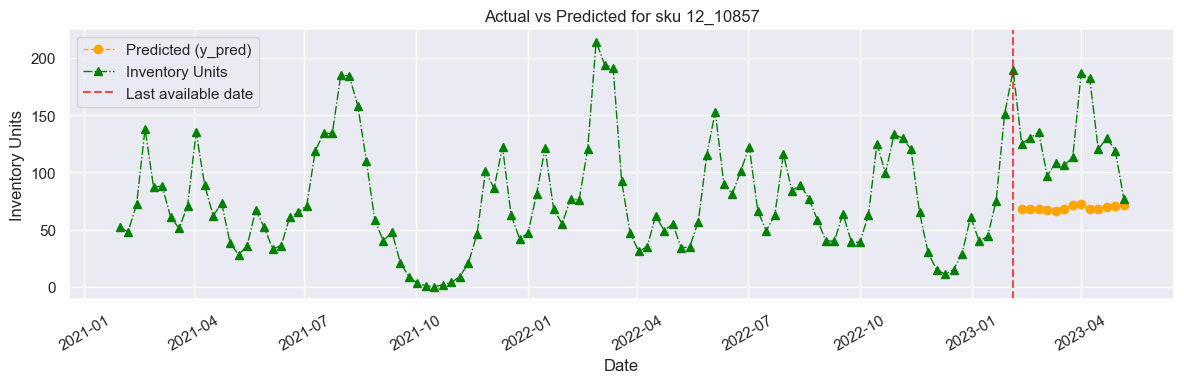

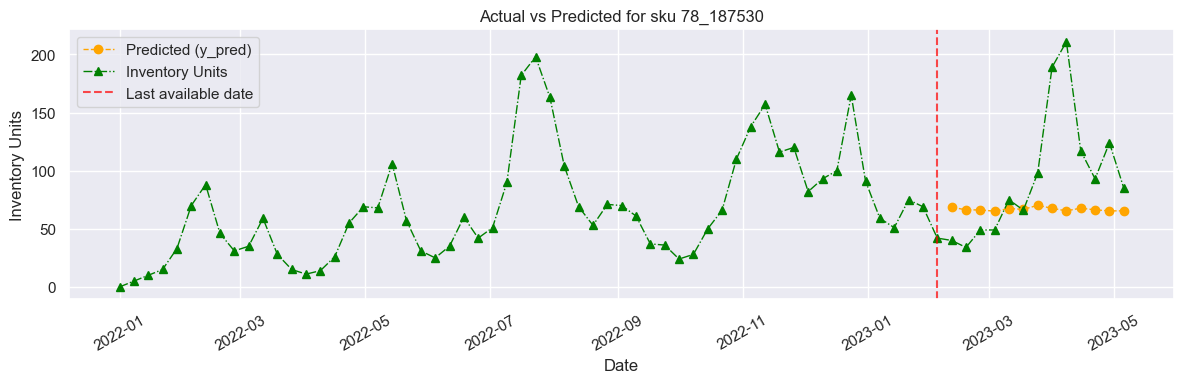

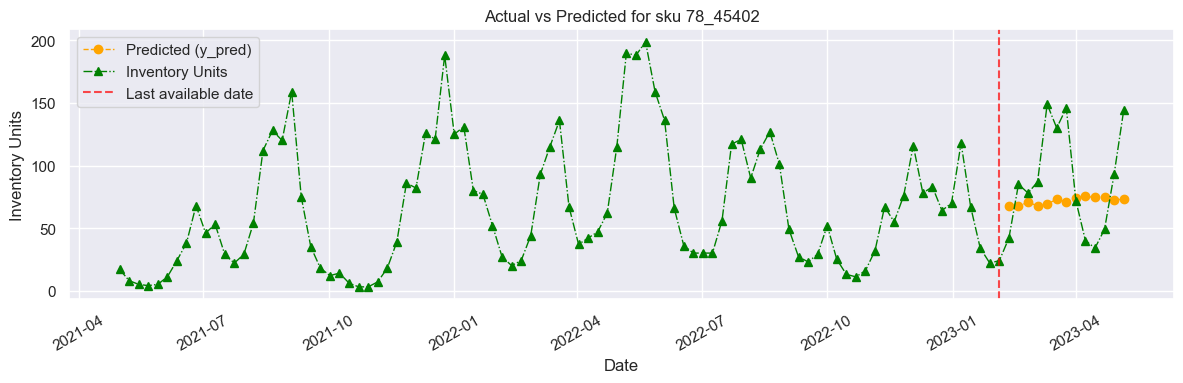

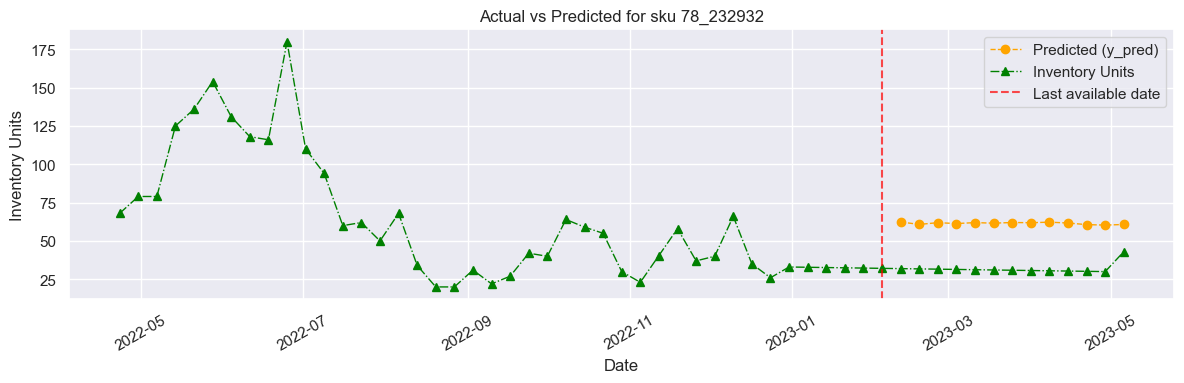

In [11]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, vline_dates=[date_present])

In [13]:
df_preds[df_preds['sku'] == '96_129297']

,sku,y_pred
date,,
2023-02-11,96_129297,101.138355


In [16]:
df_kaggle[df_kaggle['sku'] == '96_129297'].sort_values('date').tail(13)

,date,sku,id,year_week,product_number,reporterhq_id,prod_category,display_size,segment,sales_units,...,inventory_units_lag_13,sales_units_lag_13,sales_units_lag_14,sales_units_lag_15,sales_units_rolling_mean_4w,sales_units_rolling_std_4w,sales_units_rolling_sum_4w,sales_units_rolling_mean_8w,sales_units_rolling_std_8w,sales_units_rolling_sum_8w
0,2022-12-03,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,75.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-10,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,77.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-17,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,80.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-24,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,83.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-31,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,85.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-01-07,96_129297,202248-129297,202248.0,129297,96,Doraemon,15.6,Gaming,88.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-01-14,96_129297,202302-129297,202302.0,129297,96,Doraemon,15.6,Gaming,91.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-01-21,96_129297,202302-129297,202302.0,129297,96,Doraemon,15.6,Gaming,63.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-01-28,96_129297,202304-129297,202304.0,129297,96,Doraemon,15.6,Gaming,35.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-02-04,96_129297,202304-129297,202304.0,129297,96,Doraemon,15.6,Gaming,18.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Hyperparameters

In [29]:
param_distributions = {
    "learning_rate": scipy.stats.uniform(loc=0.003, scale=0.19),  # Default is 0.1. Ranges from loc to loc+scale.
    "num_leaves": scipy.stats.randint(8, 256),  # Default is 31
    "max_depth": np.append(-1, np.arange(3, 16)),  # Default is -1
    "min_child_samples": scipy.stats.randint(5, 300),  # Default is 20. AKA min_data_in_leaf.
    "subsample": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1. AKA bagging_fraction.
    "colsample_bytree": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1.0. AKA feature_fraction.
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],  # Default is 0. AKA lambda_l1.
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100],  # Default is 0. AKA lambda_l2.
    "n_estimators": [10, 50, 100, 500, 1000, 1500, 2000, 5000] # Default is 100.
}

In [ ]:
model = LGBMRegressor(**lgb_params)
model.fit(X=X_train, y=y_train)

In [37]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [ ]:
# cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
# model = lgb.LGBMRegressor()
# parameters = {
#     "max_depth": [3, 4, 6, 5, 10],
#     "num_leaves": [10, 20, 30, 40, 100, 120],
#     "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
#     "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
#     "colsample_bytree": [0.3, 0.5, 0.7, 1]
# }


# grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
# grid_search.fit(X_train, y_train)

In [ ]:
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=40,
    cv=3,
    # cv=sklearn.model_selection.ShuffleSplit(n_splits=1, test_size=.25, random_state=46),  # Train/test alternative to k-folds
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
    )

In [35]:
fc_model = LightGBMForecastingModel(hyperparameters=lgb_params)
fc_model.train(X_train, y_train)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=fc_model,
    param_distributions=param_distributions,
    n_iter=40,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)


In [33]:
random_search.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train)],
    callbacks=[lgb.early_stopping(20)]
)

InvalidParameterError: The 'estimator' parameter of RandomizedSearchCV must be an object implementing 'fit'. Got <utils.utils_models.LightGBMForecastingModel object at 0x145fd7650> instead.

In [72]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()
optimal_params["n_estimators"] = best_model.best_iteration_

In [73]:
best_model

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.8029677051366595),
              feature_fraction=0.379,
              learning_rate=np.float64(0.05385151267936273),
              max_depth=np.int64(5), metric='rmse', min_child_samples=239,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=50,
              num_leaves=158, objective='regression', random_state=222,
              reg_alpha=2, reg_lambda=20,
              subsample=np.float64(0.6624990112594646), verbosity=-1)

In [74]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': np.float64(0.8029677051366595),
 'importance_type': 'split',
 'learning_rate': np.float64(0.05385151267936273),
 'max_depth': np.int64(5),
 'min_child_samples': 239,
 'min_child_weight': 0.034,
 'min_split_gain': 0.0,
 'n_estimators': 0,
 'n_jobs': None,
 'num_leaves': 158,
 'objective': 'regression',
 'random_state': 222,
 'reg_alpha': 2,
 'reg_lambda': 20,
 'subsample': np.float64(0.6624990112594646),
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'bagging_fraction': 0.418,
 'bagging_seed': 11,
 'feature_fraction': 0.379,
 'metric': 'rmse',
 'min_data_in_leaf': 106,
 'verbosity': -1}